In [6]:
# !pip install easyocr
# !pip install git+https://github.com/JaidedAI/EasyOCR.git
!pip install keras-ocr


# !apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

!pip install -q transformers
!pip install -q -U sentencepiece
# !pip install bidi


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [7]:
# import easyocr
import pytesseract
import keras_ocr

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import cv2
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


#Pipeline
- grayscale
- blur
- threshold - OTSU, Kaitler ATAL
- OCR

In [8]:
df = pd.read_csv('/content/gdrive/My Drive/MSc Project/OCR_Plate_Data.csv')

In [9]:
# easy = easyocr.Reader(['en'])

# model = 'microsoft/trocr-large-printed' #try both
model = 'microsoft/trocr-base-printed'
processor = TrOCRProcessor.from_pretrained(model)
model = VisionEncoderDecoderModel.from_pretrained(model).to(device)

pipeline = keras_ocr.pipeline.Pipeline()

pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'

)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [10]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def preprocess_image(image):
  image = cv2.imread(file_path)
  gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


  edges = cv2.Canny(gray, 50, 150, apertureSize=3)
  contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)
  rect = cv2.minAreaRect(largest_contour)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  ordered_box = order_points(box)

  (tl, tr, br, bl) = ordered_box
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype="float32")

  M = cv2.getPerspectiveTransform(ordered_box, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))



  # blurred = cv2.medianBlur(gray, 3)
  # threshed = cv2.threshold(blurred, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


  return warped







In [11]:
tess_preds = []
# easyocr_preds = []
keras_preds = []
tr_preds = []

tesseract_times = []
# easy_ocr_times = []
keras_times = []
trOCR_times = []

counter = 0
for index, row in df.iterrows():
  file_path = row['image paths']
  img = preprocess_image(file_path)

  # tesseract inference
  start_time = time.time()
  txt = pytesseract.image_to_string(img)
  end_time = time.time()
  tesseract_times.append(end_time - start_time)
  tess_preds.append(txt)

  # easy ocr inference
  # start_time = time.time()
  # txt = easy.readtext(img)
  # end_time = time.time()
  # easy_ocr_times.append(end_time - start_time)
  # easyocr_preds.append(''.join([unit[1] for unit in txt]))

  # # Keras ocr inference
  start_time = time.time()
  images = [keras_ocr.tools.read(url) for url in [file_path]]
  txt = pipeline.recognize(images)
  end_time = time.time()
  keras_times.append(end_time - start_time)
  keras_preds.append(''.join([unit[0] for unit in txt[0]]))



  # TrOCR inference
  image = Image.open(file_path).convert('RGB')
  start_time = time.time()
  pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  end_time = time.time()
  trOCR_times.append(end_time - start_time)
  tr_preds.append(generated_text)



<ipython-input-10-65cd7ca89054>:21: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


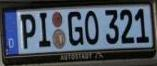

In [12]:
path = df['image paths'].iloc[1]
img = cv2.imread(path)
cv2_imshow(img)

In [13]:

df['Tesseract_Pred'] = tess_preds
# df['Easy_OCR_Pred'] = easyocr_preds
df['Keras_Pred'] = keras_preds
df['TrOCR_Pred'] =tr_preds

df['Tesseract_times'] = tesseract_times
# df['Easy_OCR_times'] = easy_ocr_times
df['Keras_times'] = keras_times
df['TrOCR_times'] = trOCR_times



In [14]:
df['Tesseract_Pred'] = df['Tesseract_Pred'].str.replace(' ', '').str.upper()
# df['Easy_OCR_Pred'] = df['Easy_OCR_Pred'].str.replace(' ', '').str.upper()
df['Keras_Pred'] = df['Keras_Pred'].str.replace(' ', '').str.upper()
df['TrOCR_Pred'] = df['TrOCR_Pred'].str.replace(' ', '').str.upper()
df['annotations'] = df['annotations'].str.replace(' ', '').str.upper()

df['Tesseract_Pred'] = df['Tesseract_Pred'].str.replace(r'\W+', '', regex=True).str.upper()
# df['Easy_OCR_Pred'] = df['Easy_OCR_Pred'].str.replace(r'\W+', '', regex=True).str.upper()
df['Keras_Pred'] = df['Keras_Pred'].str.replace(r'\W+', '', regex=True).str.upper()
df['TrOCR_Pred'] = df['TrOCR_Pred'].str.replace(r'\W+', '', regex=True).str.upper()
df['annotations'] = df['annotations'].str.replace(r'\W+', '', regex=True).str.upper()


In [15]:
df['annotations'].iloc[0], tess_preds, keras_preds, tr_preds

('DEL6',
 ['\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '/ THEME\n\x0c',
  '\x0c',
  '\x0c',
  '\\ RAVZ NAT I\n\x0c',
  ' \n\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  'NBT\n\x0c',
  '\x0c',
  'Y Bo\n\x0c',
  '\x0c',
  'IS\n\x0c',
  '\x0c',
  'S666 WSY\n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '| WMG4 UMA |\n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  'Hu. 341 A\n\x0c',
  '| SA22 YLP |\n\x0c',
  ' \n\x0c',
  ' \n\n \n\x0c',
  ' \n\x0c',
  '(tT)\n\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  'IP\n\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  ' \n\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  'Bh\n\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  '1ELR |\n\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  '\x0c',
  ' \n\x0c',
  '\x0c',


In [16]:
df

,image paths,annotations,Tesseract_Pred,Keras_Pred,TrOCR_Pred,Tesseract_times,Keras_times,TrOCR_times
0,/content/gdrive/My Drive/MSc Project/Plate Ima...,DEL6,,DELO3,660,0.175005,8.316624,1.108274
1,/content/gdrive/My Drive/MSc Project/Plate Ima...,PIG0321,,321GOPIO,PIG0321,0.106395,2.778533,0.141879
2,/content/gdrive/My Drive/MSc Project/Plate Ima...,IMYH2F,,VIYHEF,JANYH2F,0.097867,2.336051,0.175168
3,/content/gdrive/My Drive/MSc Project/Plate Ima...,XF1521,,X511,XF1521,0.172746,2.388413,0.196200
4,/content/gdrive/My Drive/MSc Project/Plate Ima...,BELIZECAC26727BELIZECITY,,LLUZECA26121AELEECILY,C26727,0.096634,2.907619,0.090219
...,...,...,...,...,...,...,...,...
190,/content/gdrive/My Drive/MSc Project/Plate Ima...,KM69ZMY,,,KR69ZNY,0.100599,0.827788,0.104866
191,/content/gdrive/My Drive/MSc Project/Plate Ima...,SA55TRA,,SA55TRA,SA55TRA,0.100134,1.988903,0.105596
192,/content/gdrive/My Drive/MSc Project/Plate Ima...,SJ22BNO,,SJ22BNO,ESJ22BNO,0.097419,0.153142,0.128713
193,/content/gdrive/My Drive/MSc Project/Plate Ima...,LV59YGJ,,LEGYGJ,LV59YGJ,0.095521,1.050059,0.130510


#Performance
- Accuracy
- Precision
- Recall
- can maybe do a per character evaluation

In [19]:
metrics = {}
for model in df.columns[2:5]:
  true_labels = df['annotations']
  pred_labels = df[model]
  metrics[model] = {
      'Word Accuracy': accuracy_score(true_labels, pred_labels),
      'Word Precision': precision_score(true_labels, pred_labels, average='macro'),
      'Word Recall': recall_score(true_labels, pred_labels, average='macro'),
      'Word F1 Score': f1_score(true_labels, pred_labels, average='macro'),
  }

metrics_df = pd.DataFrame(metrics).T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

In [20]:
metrics_df

,Word Accuracy,Word Precision,Word Recall,Word F1 Score
Tesseract_Pred,0.015385,0.014851,0.014851,0.014851
Keras_Pred,0.107692,0.059659,0.054924,0.056345
TrOCR_Pred,0.471795,0.310469,0.307461,0.307341


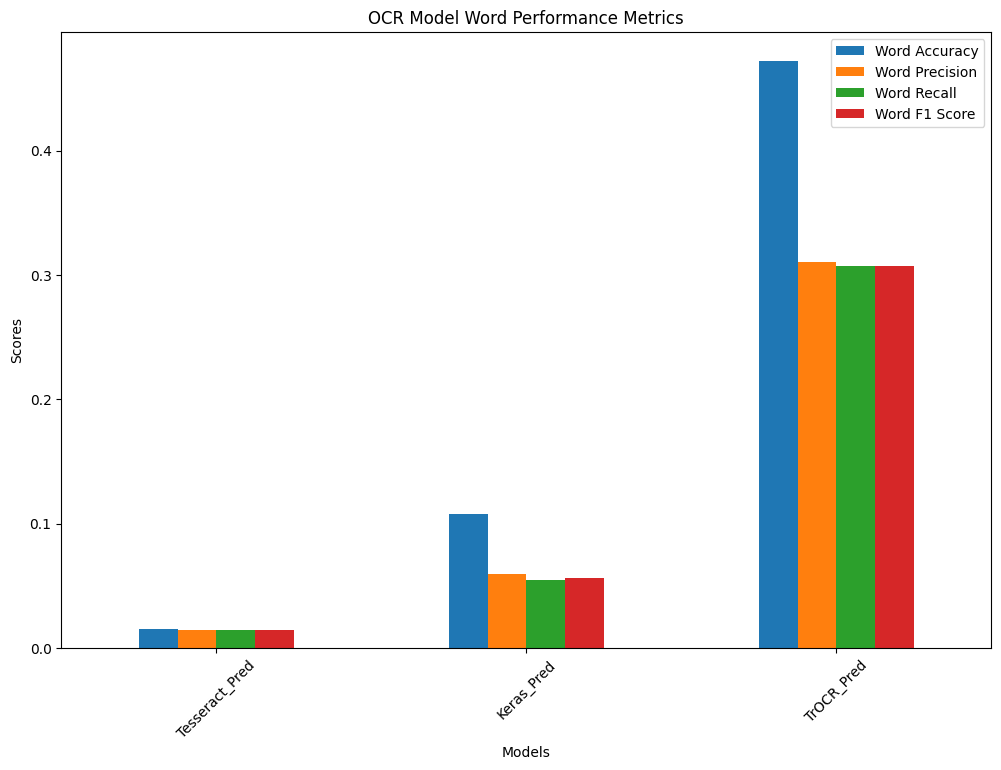

In [34]:
# Assuming metrics_df is your DataFrame
# Drop the column you want to exclude
# metrics_df_filtered = metrics_df.drop(columns=['Levanshtein Distance'])

# Plot the filtered DataFrame
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('OCR Model Word Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

#charcter level metrcis

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics import edit_distance

def character_accuracy(predicted, actual):
    correct_chars = sum(p == a for p, a in zip(predicted, actual))
    total_chars = len(actual)
    return correct_chars / total_chars

def character_accuracy_series(predicted_series, actual_series):
    accuracies = predicted_series.combine(
        actual_series,
        lambda p, a: character_accuracy(p, a),
        fill_value=""
    )
    return accuracies

def edit_distance_series(predicted_series, actual_series):
    distances = predicted_series.combine(
        actual_series,
        lambda p, a: edit_distance(p, a),
        fill_value=""
    )
    return distances

def cosine_similarity_series(predicted_series, actual_series):
    def cosine_similarity_for_pair(p, a):
        vectorizer = CountVectorizer().fit_transform([p, a])
        vectors = vectorizer.toarray()
        return cosine_similarity(vectors)[0, 1]

    similarities = predicted_series.combine(
        actual_series,
        lambda p, a: cosine_similarity_for_pair(p, a),
        fill_value=""
    )
    return similarities
def character_metrics(predicted, actual):
    tp = sum(p == a and p != "" for p, a in zip(predicted, actual))  # True positives
    fp = sum(p != a and p != "" for p, a in zip(predicted, actual))  # False positives
    fn = sum(a != "" and p != a for p, a in zip(predicted, actual))  # False negatives

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

def character_metrics_series(predicted_series, actual_series):
    metrics = predicted_series.combine(
        actual_series,
        lambda p, a: character_metrics(p, a),
        fill_value=""
    )
    p,r,f = [],[],[]
    for row in metrics:
      p.append(row[0])
      r.append(row[1])
      f.append(row[2])
    return np.mean(p), np.mean(r), np.mean(f)

In [23]:
char_metrics = {}
for model in df.columns[2:5]:
  true_labels = df['annotations']
  pred_labels = df[model]
  p,r,f = character_metrics_series(pred_labels, true_labels)
  char_metrics[model] = {
      'Character Accuracy': np.mean(character_accuracy_series(pred_labels, true_labels)),
      'Levanshtein Distance': np.mean(edit_distance_series(pred_labels, true_labels)),
      'Cosine Simularity': np.mean(cosine_similarity_series(pred_labels, true_labels)),
      'Character Precision': p,
      'Character Recall': r,
      'Character F1':f

  }

char_metrics_df = pd.DataFrame(char_metrics).T

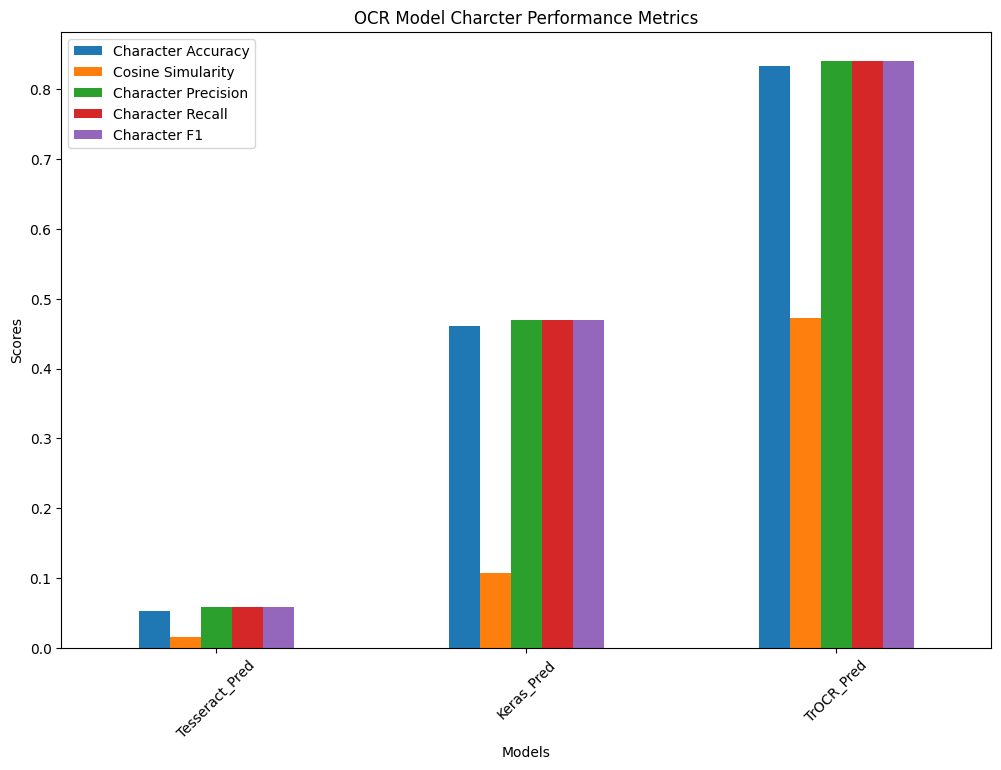

In [35]:
char_metrics_df_filtered = char_metrics_df.drop(columns=['Levanshtein Distance'])

char_metrics_df_filtered.plot(kind='bar', figsize=(12, 8))
plt.title('OCR Model Charcter Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

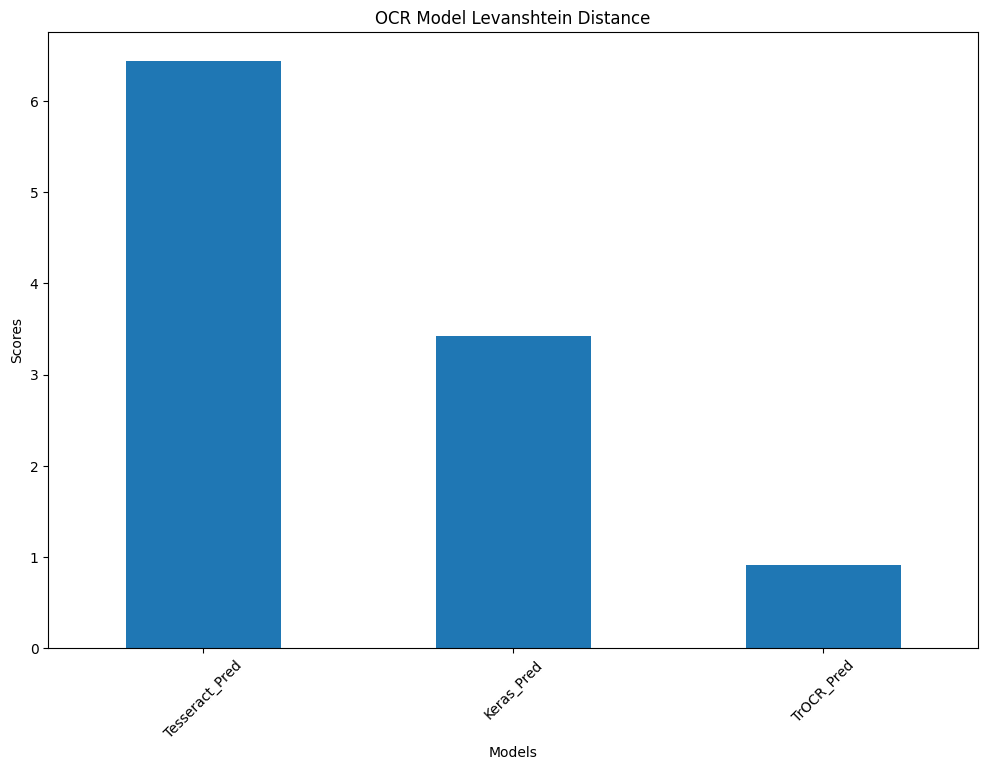

In [33]:
char_metrics_df['Levanshtein Distance'].plot(kind='bar', figsize=(12, 8))
plt.title('OCR Model Levanshtein Distance')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
# plt.legend(loc='best')
plt.show()

In [27]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def create_character_confusion_matrix(df, true_col, pred_col):
    # Initialize the confusion matrix as a defaultdict of defaultdicts
    confusion_matrix = defaultdict(lambda: defaultdict(int))

    # Iterate over the rows of the dataframe
    for index, row in df.iterrows():
        true_label = row[true_col]
        pred_label = row[pred_col]

        # Determine the length of the longest string
        max_len = max(len(true_label), len(pred_label))

        # Pad the shorter string with a placeholder (e.g., None)
        true_label = true_label.ljust(max_len, '\0')
        pred_label = pred_label.ljust(max_len, '\0')

        # Update the confusion matrix
        for true_char, pred_char in zip(true_label, pred_label):
            confusion_matrix[true_char][pred_char] += 1

    # Convert the confusion matrix to a DataFrame
    confusion_df = pd.DataFrame(confusion_matrix).fillna(0).astype(int)

    # Replace the placeholder with 'None' for better readability
    confusion_df.index = confusion_df.index.map(lambda x: x if x != '\0' else 'None')
    confusion_df.columns = confusion_df.columns.map(lambda x: x if x != '\0' else 'None')

    # Sort the index and columns alphabetically
    sorted_index = sorted(confusion_df.index)
    sorted_columns = sorted(confusion_df.columns)
    confusion_df = confusion_df.reindex(index=sorted_index, columns=sorted_columns)

    return confusion_df

# easyocr_confusion_df = create_character_confusion_matrix(df, 'annotations', 'Easy_OCR_Pred')
tesseract_confusion_df = create_character_confusion_matrix(df, 'annotations', 'Tesseract_Pred')
keras_confusion_df = create_character_confusion_matrix(df, 'annotations', 'Keras_Pred')
trocr_confusion_df = create_character_confusion_matrix(df, 'annotations', 'TrOCR_Pred')




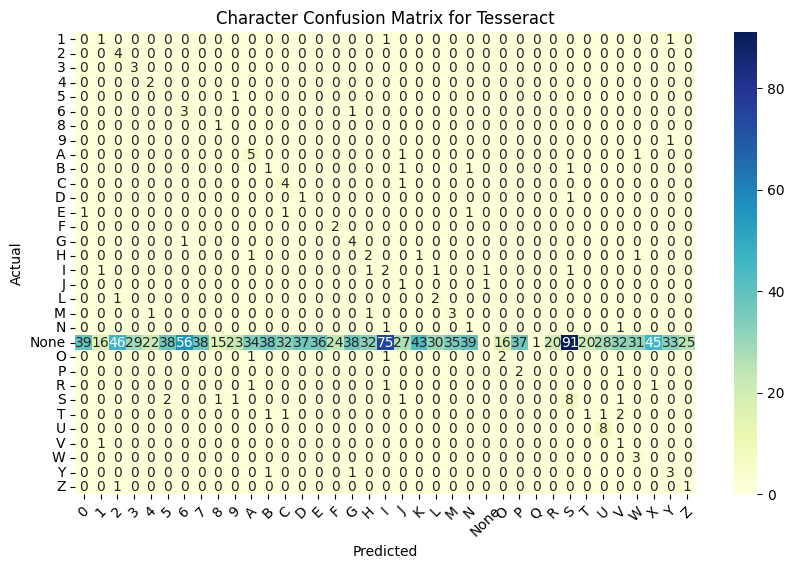

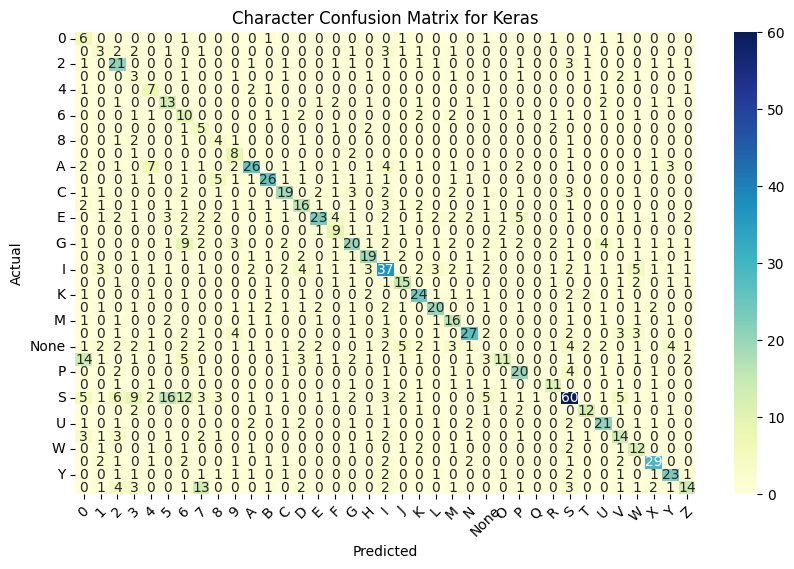

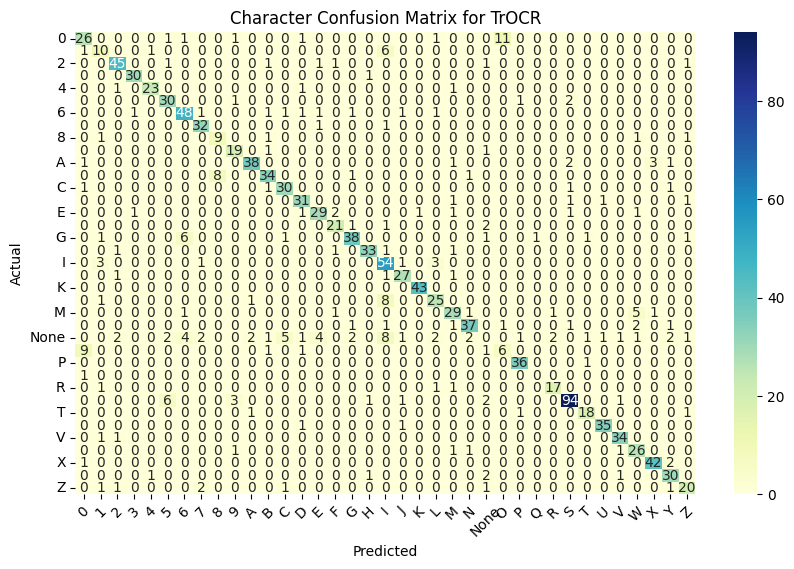

In [29]:
def plot_confusion_matrix(confusion_df, title):
  plt.figure(figsize=(10, 6))
  sns.heatmap(confusion_df, annot=True, fmt='d', cmap='YlGnBu')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Character Confusion Matrix for {title}')
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.show()

models = [tesseract_confusion_df, keras_confusion_df, trocr_confusion_df]
titles = ['Tesseract','Keras',	'TrOCR'	]
for model, title in zip(models, titles):
  plot_confusion_matrix(model, title)


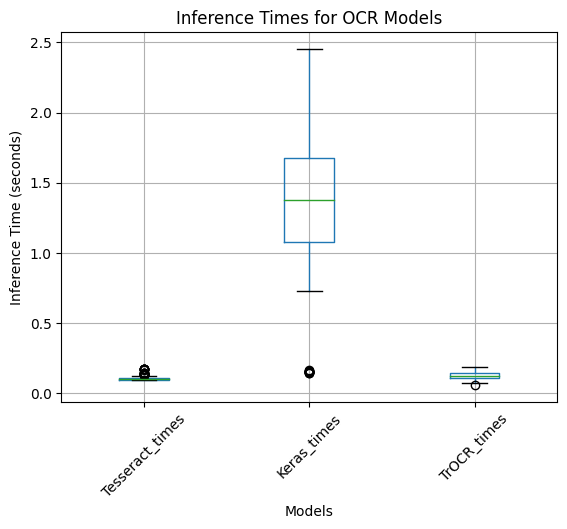

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_iqr(df, columns):
    """
    Remove outliers from specified columns of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to remove outliers from.

    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean



# Remove outliers
columns = ['Tesseract_times', 'Keras_times', 'TrOCR_times']
df_clean = remove_outliers_iqr(df, columns)

# Plot the boxplot without outliers
df_clean.boxplot(column=columns)
plt.title('Inference Times for OCR Models')
plt.xlabel('Models')
plt.ylabel('Inference Time (seconds)')
plt.xticks(rotation=45)
plt.show()

#Random sample

In [ ]:
def plot_sample(row):
  plt.imshow(cv2.imread(row["image paths"]))
  title = f'Predicted: {row["Easy_OCR_Pred"]} Actual: {row["annotations"]}'
  plt.title(title)
  plt.show()

In [ ]:
sample_size = 5
for i in range(sample_size):
  random_rows = df.sample(n=1).iloc[0]
  plot_sample(random_rows)